In [1]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from core.utils.image_analysis import *
from core.utils.basic_functions import *
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
import mat73
from torchvision.transforms import ToPILImage, PILToTensor, ToTensor
import matplotlib.image as mpimg
from PIL import Image
from scipy import stats, ndimage
from torchvision.utils import make_grid
from core.utils.CNN_scorers import TorchScorer
from core.utils.func_lib import *
from core.utils.basic_functions import *
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, KFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer, mean_squared_error


In [2]:
data_root = r"C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data"

animal_name = "Caos"
save_root = os.path.join(r"C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results", 'feature_mask_estimation', animal_name)
os.makedirs(save_root, exist_ok=True)

server_init = r"N:\PonceLab"

# Define the paths to the data
proto_exp_path = os.path.join(data_root, "evolution", f"unit_proto_{animal_name}")
scram_exp_path = os.path.join(data_root, "scram", f"unit_scram_{animal_name}")
# List .mat files in each directory
proto_exp_files = list_mat_files(proto_exp_path)
scram_exp_files = list_mat_files(scram_exp_path)

In [3]:

net_name = 'alexnet'
layer_list = ['.features.Conv2d8']

# let's do the cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
#reg = linear_model.LinearRegression()
lasso = linear_model.Lasso()
baseline_model = DummyRegressor(strategy='mean')

In [4]:
proto_exp_i = 1

proto_exp_data = load_mat_data(os.path.join(proto_exp_path, proto_exp_files[proto_exp_i]))
proto_exp_info = extract_info_proto_exp(proto_exp_files[proto_exp_i])
exp_name_common = '-'.join(proto_exp_info['exp_name'].split('-')[0:2])

chan_id = int(proto_exp_data['evoled_chan'])
unit_id = int(proto_exp_data['evoled_unit'])

# the scram exp data file name is formated like this [exp_name]_exp_idXXX_chanXX_unitX.mat for example like Caos-30112023-008_expId022_chan71_unit2
# let's load the coresponded scram exp data which should be [exp_name_common]-*_chan[chan_id]_unit[unit_id].mat
scram_exp_file = [f for f in scram_exp_files if (f.count(f"chan{chan_id:02d}") and f.count(f"unit{unit_id}") and f.count(exp_name_common))]
# continue if the file is not found
if (len(scram_exp_file) == 0) or (proto_exp_data['p_evol'] > .01):
    print(f"Scrambled file not found for {proto_exp_files[proto_exp_i]}")

scram_exp_file = scram_exp_file[0]
scram_exp_info = mat73.loadmat(os.path.join(scram_exp_path, scram_exp_file))
proto_size = scram_exp_info['img_size']
proto_pos = scram_exp_info['img_pos']
protoRespMean = scram_exp_info['protoRespMean']
exp_date = scram_exp_file.split('_')[0].split('-')[1]

proto_img_top_mean = (proto_exp_data['top_mean_img_selected']) # TODO: if you add somthing here you should resize it
proto_img_scram = (scram_exp_info['final_gen_img'])
init_img = (proto_exp_data['init_img'])
proto_mask_exp = scram_exp_info['overlapped_mask_exp']
proto_mask_lin = scram_exp_info['overlapped_mask_lin']
proto_mask_lin_smoothed = ndimage.gaussian_filter(proto_mask_lin, 25)
# if mask is not the size of image_size then resize it
iamge_size = 256
if proto_mask_exp.shape[0] != iamge_size:
    proto_mask_exp = cv2.resize(proto_mask_exp, (iamge_size, iamge_size))
if proto_mask_lin.shape[0] != iamge_size:
    proto_mask_lin = cv2.resize(proto_mask_lin, (iamge_size, iamge_size))
if proto_mask_lin_smoothed.shape[0] != iamge_size:
    proto_mask_lin_smoothed = cv2.resize(proto_mask_lin_smoothed, (iamge_size, iamge_size))
# if the proto_img is not the size of image_size then resize it
if proto_img_top_mean.shape[0] != iamge_size:
    proto_img_top_mean = cv2.resize(proto_img_top_mean, (iamge_size, iamge_size))
if proto_img_scram.shape[0] != iamge_size:
    proto_img_scram = cv2.resize(proto_img_scram, (iamge_size, iamge_size))

proto_img_top_mean = uint8_image_to_pytorch(proto_img_top_mean)
proto_img_scram = uint8_image_to_pytorch(proto_img_scram)
init_img = uint8_image_to_pytorch(init_img)


# let get all imaes 
stimuli_path = proto_exp_data['stimuli_path']
images_tensor, image_name_lisst = load_all_images(stimuli_path)


scorer = TorchScorer(net_name)
unit_mask_dict, unit_tsridx_dict = set_all_unit_population_recording(scorer, layer_list)
encoded_first_image_batch, _ = encode_image(scorer, images_tensor, key=layer_list,
                                            RFresize=False, cat_layes=False)
encoded_first_image_batch = np.array(encoded_first_image_batch)
scorer.cleanup()



c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer .features.Conv2d8 all units from feature tensor of shape (256, 13, 13)
Cleanuping...
Cleanup hooks done.
Cleanup done.


In [5]:
layer_list_idx = 0
chan_max = unit_tsridx_dict[layer_list[layer_list_idx]][0].max()
H_max = unit_tsridx_dict[layer_list[layer_list_idx]][1].max()
W_max = unit_tsridx_dict[layer_list[layer_list_idx]][2].max()


# let find the coresponing image encoding to each resonce, we should use all_img_name
# to find the index of the image in the images_tensor
mised_img = 0
cell_resp_raw = proto_exp_data['evoke_resp'][(proto_exp_data['spikeID'] == proto_exp_data['evoled_chan']) & (proto_exp_data['unitID'] == proto_exp_data['evoled_unit']), :].squeeze()
cell_resp_coresponing_img_encoded = np.nan * np.ones((cell_resp_raw.shape[0], np.shape(encoded_first_image_batch)[2]))

for ii, img in enumerate(proto_exp_data['all_img_name']):
    # check if wher the img is contained in the image_name_list, img is a string and image_name_list is numpy array of strings
    # let's find the index of the img name is contained in the image_name_list
    idx = [i for i, name in enumerate(image_name_lisst) if name in img]
    if len(idx) > 0:
        idx = idx[0]
        cell_resp_coresponing_img_encoded[ii, :] = encoded_first_image_batch[layer_list_idx, idx, :]
    else:
        mised_img += 1
# let's remove the nan values fron the cell_resp_coresponing_img_encoded and cell_resp
idx = ~np.isnan(cell_resp_coresponing_img_encoded).any(axis=1)
cell_resp_coresponing_img_encoded = cell_resp_coresponing_img_encoded[idx, :]
cell_resp = cell_resp_raw[idx] # TO DO -> BAD IDEA TO REMOVE THE MISSED IMAGES IN THE SAME VARIABLE
print(f"Missed images: {cell_resp_coresponing_img_encoded.shape[0] - np.sum(idx)}")

Missed images: 0


In [6]:
chan_id

92

In [7]:
layer_list_idx = 0
chan_max = unit_tsridx_dict[layer_list[layer_list_idx]][0].max()
H_max = unit_tsridx_dict[layer_list[layer_list_idx]][1].max()
W_max = unit_tsridx_dict[layer_list[layer_list_idx]][2].max()

r2_mask_grid_mean = np.zeros([H_max+1, W_max+1])
r2_mask_grid_folds = np.zeros([H_max+1, W_max+1, kf.get_n_splits()])
r2_mask_permuted_grid_mean = np.zeros([H_max+1, W_max+1])
r2_mask_permuted_grid_folds = np.zeros([H_max+1, W_max+1, kf.get_n_splits()])

for ih in range(H_max+1):
    for iw in range(W_max+1):
        idx_mask = np.where((unit_tsridx_dict[layer_list[layer_list_idx]][1] == ih) & (unit_tsridx_dict[layer_list[layer_list_idx]][2] == iw))[0]
        cell_resp_coresponing_img_encoded_mask = cell_resp_coresponing_img_encoded[:, idx_mask]       
        scores_real = cross_val_score(lasso, cell_resp_coresponing_img_encoded_mask, cell_resp, cv=kf)

        # let permute the cell_resp and repeat the cross_val_score
        cell_resp_permuted = np.random.permutation(cell_resp)
        scores_permuted = cross_val_score(lasso, cell_resp_coresponing_img_encoded_mask, cell_resp_permuted, cv=kf)
        
        r2_mask_grid_mean[ih, iw] = np.mean(scores_real)
        r2_mask_grid_folds[ih, iw, :] = scores_real
        r2_mask_permuted_grid_mean[ih, iw] = np.mean(scores_permuted) #TODO: we need 10 of this :((
        r2_mask_permuted_grid_folds[ih, iw, :] = scores_permuted



Best r2: 0.27930632741931544


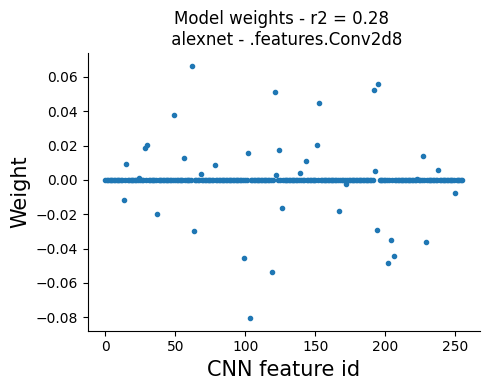

In [22]:
# let's find ih, iw that gives the best r2
ih_max, iw_max = np.unravel_index(np.argmax(r2_mask_grid_mean, axis=None), r2_mask_grid_mean.shape)
# let's find the best r2
r2_max = r2_mask_grid_mean[ih_max, iw_max]
print(f"Best r2: {r2_max}")
# let's get the model weights for the best r2
best_col_idx_mask = np.where((unit_tsridx_dict[layer_list[layer_list_idx]][1] == ih_max) & (unit_tsridx_dict[layer_list[layer_list_idx]][2] == iw_max))[0]
cell_resp_coresponing_img_encoded_mask = cell_resp_coresponing_img_encoded[:, best_col_idx_mask]
lasso.fit(cell_resp_coresponing_img_encoded_mask, cell_resp)
model_weights = lasso.coef_
# let's plot the whaites
plt.figure(figsize=[5, 4])
plt.plot(model_weights, '.')
plt.title(f'Model weights - r2 = {r2_max:.2f} \n {net_name} - {layer_list[layer_list_idx]}')
plt.xlabel('CNN feature id', fontsize=15)
plt.ylabel('Weight', fontsize=15)
plt.tight_layout()


In [51]:

from core.utils.Optimizers import CholeskyCMAES
from core.utils.GAN_utils import upconvGAN
from core.utils.layer_hook_utils import get_module_names

scorer = TorchScorer(net_name)
unit_mask_dict, unit_tsridx_dict = set_all_unit_population_recording(scorer, layer_list)

G = upconvGAN("fc6").cuda().eval()
new_codes = np.random.randn(1, 4096)
optimizer = CholeskyCMAES(space_dimen=4096, init_code=new_codes, init_sigma=3.0,)
steps = 150
scores_tracker = []
steps_tracker = []
modeled_proto = []
for i in range(steps):
    latent_code = torch.from_numpy(np.array(new_codes)).float()
    imgs = G.visualize(latent_code.cuda()).cpu()
    _, resp_mat = scorer.score_tsr(imgs)
    col_resp = resp_mat[layer_list[layer_list_idx]][:,best_col_idx_mask]
    # let multiply the resp_mat[i] to the model_weights (bot are the same size array) I want one to one multiplication
    scores = np.array([np.dot(col_resp[i], model_weights) for i in range(col_resp.shape[0])])
    new_codes = optimizer.step_simple(scores, new_codes, )
    scores_tracker.extend(scores)
    steps_tracker.extend([i]*len(scores))
   # best_img_tracker.extend([imgs[np.argmax(scores)]])
    # print each 20 run 
    #print("step %d score %.3f (%.3f) (norm %.2f )" % (
    #           i, scores.mean(), scores.std(), latent_code.norm(dim=1).mean(),))
scores_tracker = np.array(scores_tracker)
steps_tracker = np.array(steps_tracker)

modeled_proto.append(imgs[np.argmax(scores)])
for j in range(2):
    new_codes = np.random.randn(1, 4096)
    optimizer = CholeskyCMAES(space_dimen=4096, init_code=new_codes, init_sigma=3.0,)
    for i in range(steps):
        latent_code = torch.from_numpy(np.array(new_codes)).float()
        imgs = G.visualize(latent_code.cuda()).cpu()
        _, resp_mat = scorer.score_tsr(imgs)
        col_resp = resp_mat[layer_list[layer_list_idx]][:,best_col_idx_mask]
        # let multiply the resp_mat[i] to the model_weights (bot are the same size array) I want one to one multiplication
        scores = np.array([np.dot(col_resp[i], model_weights) for i in range(col_resp.shape[0])])
        new_codes = optimizer.step_simple(scores, new_codes, )
    modeled_proto.append(imgs[np.argmax(scores)])
scorer.cleanup()

Layer .features.Conv2d8 all units from feature tensor of shape (256, 13, 13)
Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050
Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050
Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050
Cleanuping...
Cleanup hooks done.
Cleanup done.


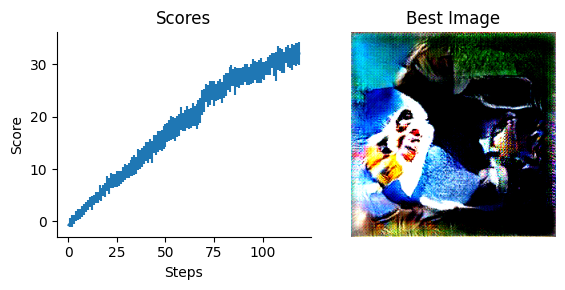

In [49]:
# let's plot the scores and the best image
scores_means = np.array([np.mean(scores_tracker[steps_tracker == i]) for i in range(steps)])
scores_std = np.array([np.std(scores_tracker[steps_tracker == i]) for i in range(steps)])
best_model_proto = modeled_proto[0]
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].errorbar(range(steps), scores_means, yerr=scores_std)
ax[0].set_title("Scores")
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Steps")
ax[1].imshow(ToPILImage()(best_model_proto))
ax[1].set_title("Best Image")
ax[1].axis('off')
plt.tight_layout()
plt.show()


In [11]:
# let run an anova test to see if the r2_mask_grid_mean is significantly different from r2_mask_permuted_grid_mean
f_val, p_val = stats.f_oneway(r2_mask_grid_mean.flatten(), r2_mask_permuted_grid_mean.flatten())
p_val

0.0

In [12]:
# let run an anova test to see if the r2_mask_grid_folds have a colomn that is significantly different from r2_mask_permuted_grid_folds
f_val, p_val = stats.f_oneway(r2_mask_grid_folds, r2_mask_permuted_grid_folds) 
p_val

array([[7.87863058e-26, 2.14434225e-21, 1.03801011e-20, 3.34138777e-20,
        1.76785604e-27],
       [7.13461672e-24, 1.86298061e-20, 1.39054322e-20, 1.03431237e-21,
        1.29596945e-22],
       [1.19316738e-24, 1.09410541e-20, 3.30240376e-19, 7.41968997e-20,
        2.08261114e-18],
       [2.42341723e-22, 5.74677228e-21, 5.88309949e-20, 4.55623590e-17,
        9.83432946e-19],
       [2.39681878e-18, 1.37875365e-21, 4.39084440e-21, 1.80136156e-17,
        2.46283085e-19],
       [1.29128225e-18, 8.48064731e-23, 3.26118379e-21, 9.43560484e-20,
        2.66712176e-18],
       [2.65779130e-21, 1.11204441e-20, 1.90391551e-24, 1.04451088e-23,
        4.52483405e-22],
       [5.52575869e-22, 4.45133847e-22, 5.57079157e-28, 8.31238438e-26,
        7.48941453e-24],
       [2.95925399e-22, 1.31305399e-24, 5.76250675e-27, 3.38350045e-23,
        1.48475311e-23],
       [5.20472328e-21, 2.42931728e-23, 1.06538853e-26, 1.22330466e-21,
        4.20710289e-22],
       [1.03032194e-23, 3.7687

Correlation between the estimated mask and the real mask: 0.693335440106286
Correlation between the permuted estimated mask and the real mask: -0.7634260774972018


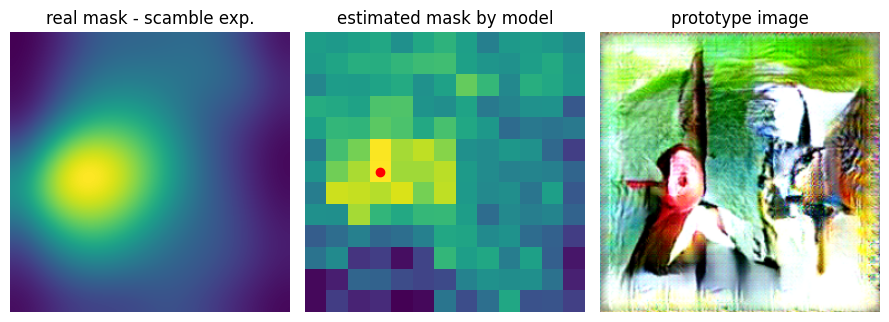

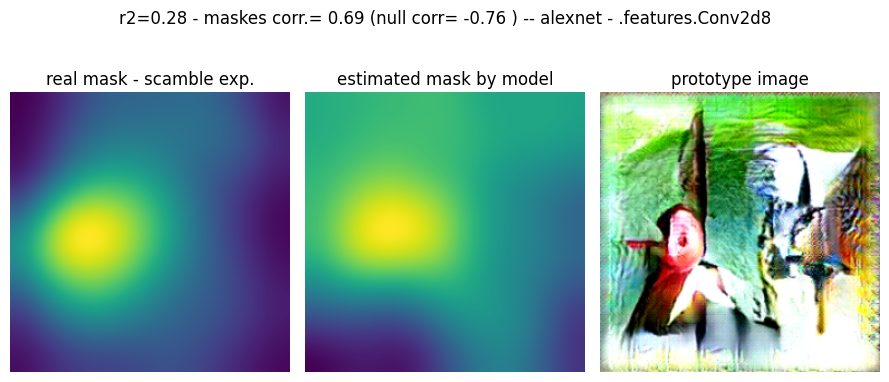

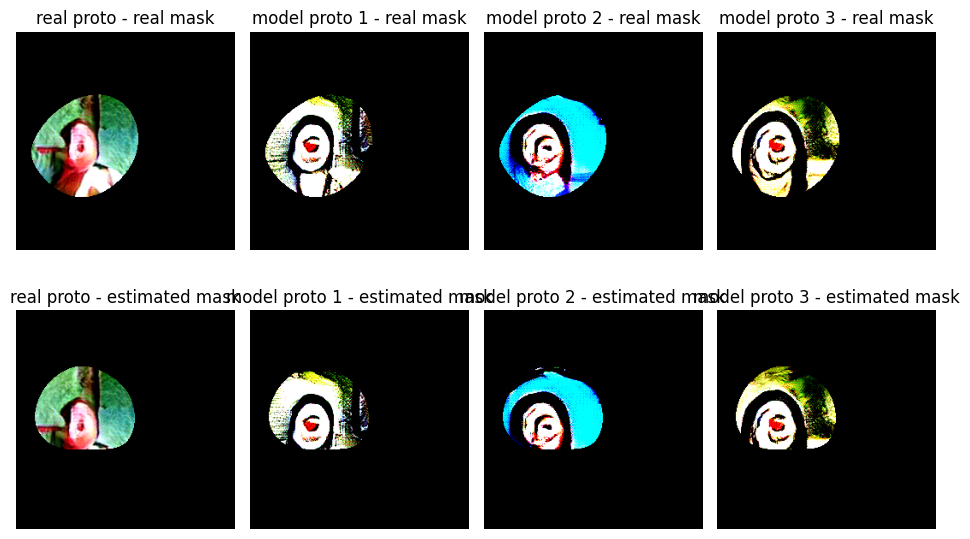

In [53]:
# let plot the r2_mask_grid_mean as a heatmap
ih_max, iw_max = np.unravel_index(np.argmax(r2_mask_grid_mean, axis=None), r2_mask_grid_mean.shape)

fig, ax = plt.subplots(1, 3, figsize=(9, 4))

ax[0].imshow(proto_mask_lin_smoothed)
ax[0].set_title('real mask - scamble exp.')
ax[0].axis('off')

ax[1].imshow(r2_mask_grid_mean)
ax[1].set_title('estimated mask by model')
# add a red dot to the max value
ax[1].plot(iw_max, ih_max, 'ro')
ax[1].axis('off')

ax[2].imshow(ToPILImage()(proto_img_scram))
ax[2].set_title('prototype image')
ax[2].axis('off')



plt.tight_layout()
# let's save the figure

# let convert the r2_mask_grid_mean to the same size as proto_img_scram by lin interpolation
r2_mask_grid_mean_resized = cv2.resize(r2_mask_grid_mean, (iamge_size, iamge_size))
r2_mask_permuted_grid_mean_resized = cv2.resize(r2_mask_permuted_grid_mean, (iamge_size, iamge_size))
# let smooth it now
r2_mask_grid_mean_resized = ndimage.gaussian_filter(r2_mask_grid_mean_resized, 25)
r2_mask_permuted_grid_mean_resized = ndimage.gaussian_filter(r2_mask_permuted_grid_mean_resized, 25)

# let get the correlation between the r2_mask_grid_mean_resized and the proto_mask_lin_smoothed
corr = np.corrcoef(r2_mask_grid_mean_resized.flatten(), proto_mask_lin_smoothed.flatten())[0, 1]
print(f"Correlation between the estimated mask and the real mask: {corr}")
corr_permuted = np.corrcoef(r2_mask_permuted_grid_mean_resized.flatten(), proto_mask_lin_smoothed.flatten())[0, 1]
print(f"Correlation between the permuted estimated mask and the real mask: {corr_permuted}")

r2_mask_grid_mean_resized_binary = make_binary_mask_torch(torch.from_numpy(r2_mask_grid_mean_resized), x_std=1)
proto_mask_lin_smoothed_binary = make_binary_mask_torch(torch.from_numpy(proto_mask_lin_smoothed), x_std=1)

# let plot the r2_mask_grid_mean_resized as a heatmap
fig, ax = plt.subplots(1, 3, figsize=(9, 4.3))
ax[0].imshow(proto_mask_lin_smoothed)
ax[0].set_title('real mask - scamble exp.')
ax[0].axis('off')

ax[1].imshow(r2_mask_grid_mean_resized)
ax[1].set_title('estimated mask by model')
ax[1].axis('off')

ax[2].imshow(ToPILImage()(proto_img_scram))
ax[2].set_title('prototype image')
ax[2].axis('off')
# set that subtitle title 
fig.suptitle(f"r2={r2_max:.2f} - maskes corr.= {corr:.2f} (null corr= {corr_permuted:.2f} ) -- {net_name} - {layer_list[layer_list_idx]}")
plt.tight_layout()


# let maskes the image
proto_masked_real = proto_img_scram * proto_mask_lin_smoothed_binary
proto_masked_estimated = proto_img_scram * r2_mask_grid_mean_resized_binary

fig, ax = plt.subplots(2, 4, figsize=(9.5, 6))
ax[0, 0].imshow(ToPILImage()(proto_masked_real))
ax[0, 0].set_title('real proto - real mask')
ax[0, 0].axis('off')
for i in range(1, 4):
    ax[0, i].imshow(ToPILImage()(modeled_proto[i-1].detach().cpu() * proto_mask_lin_smoothed_binary))
    ax[0, i].set_title(f'model proto {i} - real mask')
    ax[0, i].axis('off')

ax[1, 0].imshow(ToPILImage()(proto_masked_estimated))
ax[1, 0].set_title('real proto - estimated mask')
ax[1, 0].axis('off')


for i in range(1, 4):
    ax[1, i].imshow(ToPILImage()(modeled_proto[i-1].detach().cpu() * r2_mask_grid_mean_resized_binary))
    ax[1, i].set_title(f'model proto {i} - estimated mask')
    ax[1, i].axis('off')
plt.tight_layout()




# 



In [ ]:
ax[1].get_clim()

AttributeError: 'Axes' object has no attribute 'get_clim'

In [ ]:
# let find the 

array([[0.2244367 , 0.2196733 , 0.22277237, 0.22072489, 0.21211905,
        0.21337181, 0.23062535, 0.25517413, 0.2528995 , 0.25549125,
        0.24231545, 0.2444946 , 0.25511278, 0.25476535, 0.25583651,
        0.24694068, 0.24333826, 0.24504073, 0.23611312, 0.23821848,
        0.23652875, 0.22897989, 0.22584508, 0.21982169, 0.22091858,
        0.22467606, 0.21800936],
       [0.24080783, 0.24239166, 0.23222517, 0.22441507, 0.21520735,
        0.2289947 , 0.24046272, 0.25931778, 0.25863793, 0.24732148,
        0.24544466, 0.25942954, 0.25465939, 0.25611368, 0.25495841,
        0.24948845, 0.25723868, 0.2492033 , 0.24663589, 0.24461323,
        0.24748155, 0.23978338, 0.23339041, 0.22554341, 0.22894148,
        0.22864795, 0.22338103],
       [0.2503843 , 0.2409186 , 0.2400483 , 0.23791149, 0.23851578,
        0.24508902, 0.24893039, 0.25715369, 0.24895527, 0.24327528,
        0.25687736, 0.26202868, 0.25380045, 0.25854533, 0.26343902,
        0.24614747, 0.24607966, 0.24710146, 0.2490